# Sentiment Analysis
## TextCNN Model on Appliances dataset

## Importing Libraries

In [88]:
import pandas as pd
from pathlib import Path
import json
import csv

In [89]:
%matplotlib inline
import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


#from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

## Fetching the dataset (Luxury Beauty)

In [90]:
df = pd.read_json (r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Luxury_Beauty.json', lines=True)
df.to_csv (r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Luxury_Beauty.csv', index = None)

In [91]:
#Making Dataframe
review_df = pd.read_csv(r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Luxury_Beauty.csv')
review_df

C:\Users\Neha Sharma\AppData\Local\Temp\ipykernel_8644\953967520.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  review_df = pd.read_csv(r'C:\Users\Neha Sharma\Desktop\Data Mining_project\Luxury_Beauty.csv')


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
574623,5,NaN,True,"03 20, 2017",AHYJ78MVF4UQO,B01HIQEOLO,Lori Fox,Great color and I prefer shellac over gel,Five Stars,1489968000,NaN,NaN
574624,5,NaN,True,"10 26, 2016",A1L2RT7KBNK02K,B01HIQEOLO,Elena,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,1477440000,NaN,NaN
574625,5,NaN,True,"09 30, 2016",A36MLXQX9WPPW9,B01HIQEOLO,Donna D. Harris,Great polish and beautiful color!!,Great polish!,1475193600,NaN,NaN
574626,1,2.0,True,"12 5, 2016",A23DRCOMC2RIXF,B01HJ2UY0W,Y.Y. Chen,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,1480896000,"{'Size:': ' 1.7 Fluid Ounce', 'Color:': ' Multi'}",NaN


In [95]:
#Coulmns in dataset
review_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'style',
       'image'],
      dtype='object')

## Data Cleaning

In [96]:
#Dropping the columns not required
review_df=review_df.drop(['vote','verified','reviewTime','style','reviewerName', 'unixReviewTime', 'image'],axis=1)

In [98]:
type(review_df['reviewText'][0])

str

<AxesSubplot: xlabel='overall', ylabel='count'>

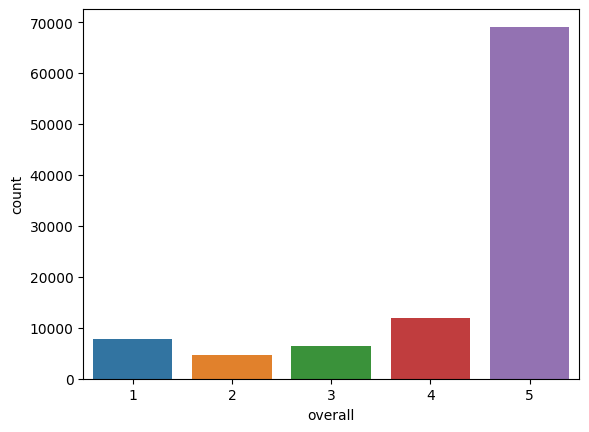

In [99]:
#Count of overall rating
sbn.countplot(x=review_df['overall'])

In [100]:
#Removing Stopwords
def data_clean( rev, remove_stopwords=True): 
    
    new_text = re.sub("[^a-zA-Z]"," ", rev)
   
    words = new_text.lower().split()
    
    if remove_stopwords:
        sts = set(stopwords.words("english"))
        words = [w for w in words if not w in sts]
    ary=[]
    eng_stemmer = english_stemmer 
    for word in words:
        ary.append(eng_stemmer.stem(word))

    
    return(ary)

In [101]:
cleaned_reviewData = []
for rev in review_df['reviewText']:
    #print(rev)
    cleaned_reviewData.append(" ".join(data_clean(str(rev))))
    
clean_summaryData = []
for rev in review_df['summary']:
    clean_summaryData.append(" ".join(data_clean(str(rev))))

In [102]:
#Fetching most frequent words from Review Text
Most_used_Words_Review =pd.Series(' '.join(cleaned_reviewData).lower().split()).value_counts()[:20]
print (Most_used_Words_Review)

use        47680
product    41811
hair       34559
love       26455
great      23943
like       21788
skin       18259
work       16983
one        16013
good       15273
smell      15055
color      14488
get        14201
shave      13964
look       13329
time       13112
dri        11660
year       11618
realli     11595
tri        11064
dtype: int64


In [103]:
#Fetching most frequent words from Review Summary
Most_used_Words_Summary = pd.Series(' '.join(clean_summaryData).lower().split()).value_counts()[:20]
print (Most_used_Words_Summary)

star       27498
five       21110
great      11448
product     8148
love        7990
good        4994
best        4408
hair        3699
work        3408
use         3037
four        2728
color       2697
like        2669
smell       2495
one         2490
shave       2028
nice        1876
skin        1821
stuff       1558
ever        1557
dtype: int64


## Data Classification and Clustering

In [104]:
#preparing matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
text_vectorizer = TfidfVectorizer(min_df=4, max_features = 1000)
test_vector = text_vectorizer.fit_transform(cleaned_reviewData)
tfidf_vector = dict(zip(text_vectorizer.get_feature_names_out(), text_vectorizer.idf_))

In [105]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Neha
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [106]:
# Sentiment Analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
sample_review = review_df.reviewText[:10]
for test in sample_review:
    test
    ss = analyser.polarity_scores(test)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print(test)

compound: 0.5423, 
neg: 0.045, 
neu: 0.811, 
pos: 0.144, 
I bought two of these 8.5 fl oz hand cream, and neither of the dispensers work.  The hand cream is wonderful, but very thick, so I don't see I can get much out by shaking it out, since the dispensers seem to be non-operable.
compound: 0.9451, 
neg: 0.026, 
neu: 0.779, 
pos: 0.195, 
Believe me, over the years I have tried many, many different hand creams. I am one of those people whose hands get so dry they have little cracks all over them.

Of all the hand creams, this is the best. It really moisturizes but doesn't leave your hands feeling greasy. And it lasts. I think a lot of lotions just have too much water in them. It has a very nice, subtle scent. I have to avoid a lot of lotions just because the scent is too strong!

I am overall very "frugal" but I think this cream is worth the money.
compound: 0.8074, 
neg: 0.0, 
neu: 0.12, 
pos: 0.88, 
Great hand lotion
compound: 0.296, 
neg: 0.174, 
neu: 0.581, 
pos: 0.244, 
This is th

In [107]:
#Kmeans clusters
from sklearn.cluster import MiniBatchKMeans

clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=clusters, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmodel = kmeans_model.fit(test_vecor)
kmodel_clusters = kmodel.predict(test_vecor)
kmodel_distances = kmodel.transform(test_vecor)
centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
values = text_vectorizer.get_feature_names_out()
for i in range(clusters):
    print("Cluster %d:" % i)
    for j in centroids[i, :5]:
        print(' %s' % values[j])
    print()

Cluster 0:
 iron
 curl
 hair
 flat
 heat

Cluster 1:
 good
 product
 price
 smell
 qualiti

Cluster 2:
 favorit
 last
 long
 time
 one

Cluster 3:
 polish
 nail
 color
 opi
 love

Cluster 4:
 stuff
 love
 great
 good
 use

Cluster 5:
 skin
 use
 nice
 product
 face

Cluster 6:
 razor
 blade
 shave
 safeti
 use

Cluster 7:
 best
 ever
 use
 product
 hair

Cluster 8:
 like
 realli
 product
 use
 feel

Cluster 9:
 shave
 cream
 use
 lather
 product

Cluster 10:
 perfect
 color
 expect
 love
 product

Cluster 11:
 hair
 product
 use
 make
 dri

Cluster 12:
 smell
 love
 great
 like
 good

Cluster 13:
 dryer
 hair
 blow
 dri
 one

Cluster 14:
 love
 product
 wife
 use
 husband

Cluster 15:
 work
 well
 use
 hair
 product

Cluster 16:
 product
 use
 excel
 love
 year

Cluster 17:
 color
 love
 great
 beauti
 opi

Cluster 18:
 great
 product
 work
 price
 fast

Cluster 19:
 coat
 top
 polish
 nail
 color



In [108]:
test_reviewText = review_df.reviewText
test_Ratings = review_df.overall
text_vectorizer = TfidfVectorizer(max_df=.8)
text_vectorizer.fit_transform(test_reviewText.values.astype('U'))
#v.fit_transform(df['Review'].values.astype('U')) 
def rate(r):
    ary2 = []
    for rating in r:
        tv = [0,0,0,0,0]
        tv[rating-1] = 1
        ary2.append(tv)
    return np.array(ary2)

In [109]:
#Review text
test_reviewText =test_reviewText[:2000]
test_reviewText

0       I bought two of these 8.5 fl oz hand cream, an...
1       Believe me, over the years I have tried many, ...
2                                       Great hand lotion
3       This is the best for the severely dry skin on ...
4       The best non- oily hand cream ever. It heals o...
                              ...                        
1995    Great stuff! Does not smell and kept me odor f...
1996    Excellent product, and although it might seem ...
1997    Sad to report that this very promising product...
1998    it didn't work as i expected it to. my underar...
1999    I have used this product for about 1 year now ...
Name: reviewText, Length: 2000, dtype: object

In [110]:
#Overall ratings
test_Ratings = test_Ratings[:2000]
test_Ratings

0       2
1       5
2       5
3       5
4       5
       ..
1995    5
1996    5
1997    1
1998    2
1999    4
Name: overall, Length: 2000, dtype: int64

In [111]:
X = text_vectorizer.transform(test_reviewText.values.astype('U')).toarray()
y = rate(test_Ratings.values)

## TextCNN Model

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1)

#After performing Oversampling (because of high amount of data in with 5 Rating)
over = SMOTE(k_neighbors=3)
X_train, y_train = over.fit_resample(X_train, y_train)

#model implementation
model = Sequential()
model.add(Dense(128,input_dim=X_train.shape[1]))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
map=model.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=10,batch_size=32,verbose=1)
model.evaluate(X_test,y_test)[1]

Epoch 1/10
57/57 [==============================] - 5s 70ms/step - loss: 1.0733 - accuracy: 0.7122 - val_loss: 0.8871 - val_accuracy: 0.7200
Epoch 2/10
57/57 [==============================] - 4s 63ms/step - loss: 0.8109 - accuracy: 0.7211 - val_loss: 0.8095 - val_accuracy: 0.7250
Epoch 3/10
57/57 [==============================] - 10s 181ms/step - loss: 0.6932 - accuracy: 0.7322 - val_loss: 0.7675 - val_accuracy: 0.7350
Epoch 4/10
57/57 [==============================] - 15s 243ms/step - loss: 0.6018 - accuracy: 0.7756 - val_loss: 0.7442 - val_accuracy: 0.7450
Epoch 5/10
57/57 [==============================] - 5s 79ms/step - loss: 0.5221 - accuracy: 0.8239 - val_loss: 0.7331 - val_accuracy: 0.7500
Epoch 6/10
57/57 [==============================] - 5s 84ms/step - loss: 0.4521 - accuracy: 0.8667 - val_loss: 0.7306 - val_accuracy: 0.7450
Epoch 7/10
57/57 [==============================] - 6s 98ms/step - loss: 0.3877 - accuracy: 0.9017 - val_loss: 0.7334 - val_accuracy: 0.7450
Epoch 8/1

0.7450000047683716

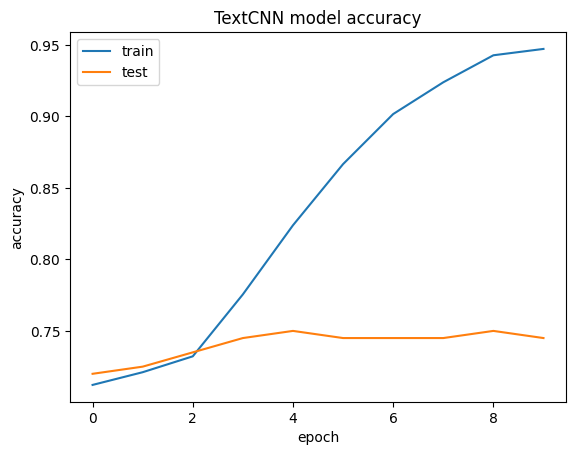

In [113]:
#TextCNN model accuracy graph
plt.plot(map.history['accuracy'])
plt.plot(map.history['val_accuracy'])
plt.title('TextCNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

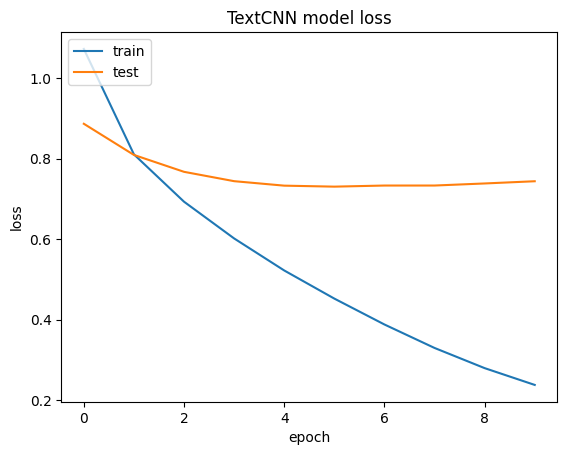

In [114]:
#TextCNN model Loss graph
plt.plot(map.history['loss'])
plt.plot(map.history['val_loss'])
plt.title('TextCNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()